# Unsupervised Learning

This notebook is dedicated to unsupervised learning, which means the data we will be examining is unlabeled. Using our methods, we may discover some hidden structure in the data. We will also perform some density estimation techniques, to see if we can apply some non-parametric probability density functions to our data.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity

from scipy import stats, integrate

from helper import *

## Dimensional Reduction.

Let's try some dimensional reduction techniques, specifically Principal Component Analysis, on Delta Air Lines' aircrafts.

Delta Air Lines (and other major airlines) has data on all of their aircrafts on their [website](http://www.delta.com/content/www/en_US/traveling-with-us/airports-and-aircraft/Aircraft.html). For example, the following image shows the specifications of AIRBUS A319 VIP.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week5/assignments/images/AIRBUS_A319_VIP.png)

### The Data

In this problem, we will use `delta.csv`, a CSV file that has aircraft data taken from the Delta Air Lines website.

In [2]:
df = pd.read_csv('~/delta.csv', index_col='Aircraft')

This data set has 34 columns (including the names of the aircrafts)
  on 44 aircrafts. It inclues both quantitative measurements such as cruising speed,
  accommodation and range in miles, as well as categorical data,
  such as whether a particular aircraft has Wi-Fi or video.
  These binary are assigned values of either 1 or 0, for yes or no respectively.

In [3]:
print(df.head())

                  Seat Width (Club)  Seat Pitch (Club)  Seat (Club)  \
Aircraft                                                              
Airbus A319                     0.0                  0            0   
Airbus A319 VIP                19.4                 44           12   
Airbus A320                     0.0                  0            0   
Airbus A320 32-R                0.0                  0            0   
Airbus A330-200                 0.0                  0            0   

                  Seat Width (First Class)  Seat Pitch (First Class)  \
Aircraft                                                               
Airbus A319                           21.0                        36   
Airbus A319 VIP                       19.4                        40   
Airbus A320                           21.0                        36   
Airbus A320 32-R                      21.0                        36   
Airbus A330-200                        0.0                         0  

## Physical Characteristics

First, let's look at the attributes related to the aircraft physical characteristics:

- Cruising Speed (mph)
- Range (miles)
- Engines
- Wingspan (ft)
- Tail Height (ft)
- Length (ft)

These six variables are about in the middle of the data frame (and it's part of your task to figure out where they are located).

- Function `plot_pairgrid()` takes a pandas.DataFrame and uses [seaborn.PairGrid](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.PairGrid.html#) to visualize the attributes related to the six physical characteristics listed above. The plots on the diagonal are histograms of corresponding attributes, and the off-diagonal are scatter plots.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


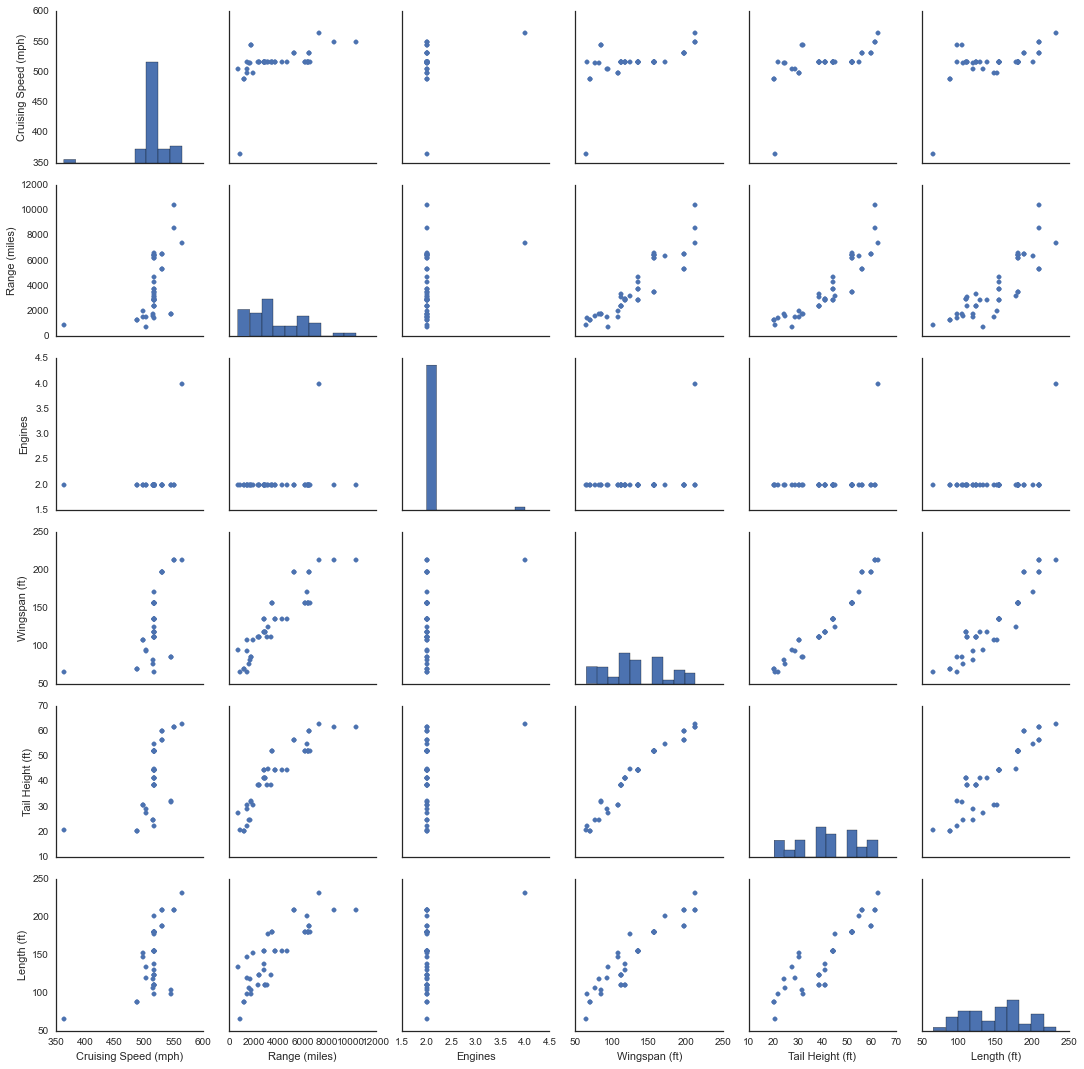

In [4]:
pg = plot_pairgrid(df)

We can see that there are pretty strong positive correlations between all these variables, as all of them are related to the aircraft’s overall size. Remarkably there is an almost perfectly linear relationship between wingspan and tail height.

The exception here is the variable right in the middle which is the number of engines. There is one lone outlier which has four engines, while all the other aircraft have two. In this way the engines variable is really more like a categorical variable, but we shall as the analysis progresses that this is not really important, as there are other variables which more strongly discern the aircraft from one another than this.

### Principal Components Analysis (A naive approach)

Next, let’s say we know nothing about dimensionality reduction techniques and just naively apply principle components to the data.

- Function `fit_pca()` takes a pandas.DataFrame and uses [sklearn.decomposition.PCA](http://scikit-learn.org/0.16/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) to fit a PCA model on all values of `df`.

In [5]:
# we keep all components by setting n_components = no of cols in df
pca_naive = fit_pca(df, n_components=df.shape[1])

### Plot explained variance

- Function `plot_naive_variance()` visualizes the percentage of variance explained by each of the selected components.

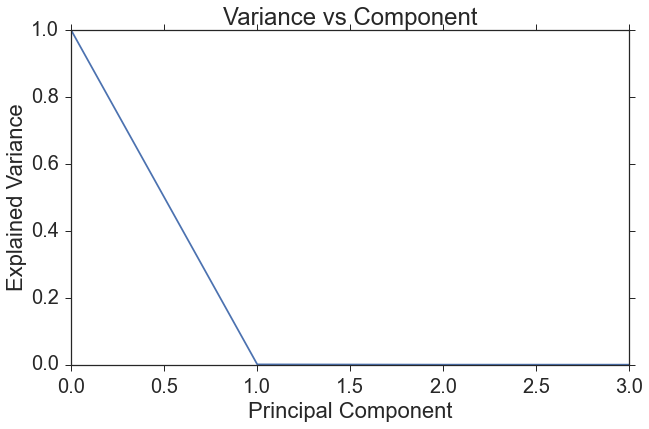

In [6]:
naive_var = plot_naive_variance(pca_naive)

Taking this naive approach, we can see that the first principal component accounts for 99.9% of the variance in the data. (Note the y-axis is on a log scale.) Looking more closely, we see that the first principle component is just the range in miles.

In [7]:
abs_val = np.abs(pca_naive.components_[0])
max_pos = abs_val.argmax()
max_val = abs_val.max()

print('"{0}" accounts for {1:0.3f} % of the variance.'.format(df.columns[max_pos], max_val))

"Range (miles)" accounts for 0.999 % of the variance.


This is because the scale of the different variables in the data set is quite variable.

### Standardization

PCA is a scale-dependent method. For example, if the range of one column is [-100, 100],
  while the that of another column is [-0.1, 0.1], PCA will place more weight
  on the feature with larger values.
  One way to avoid this is to *standardize* a data set by
  scaling each feature so that the individual features all look like
  Gausssian distributions with zero mean and unit variance.
 
  
- Function `standardize()` uses [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler) to scale each features so that they have zero mean and unit variance.

In [8]:
scaled = standardize(df)

In [9]:
# we keep only 10 components
n_components = 10
pca = fit_pca(scaled, n_components=n_components)

### Plot explained variance

- We'll visualize the explained variance of the first 10 principal components from the scaled data.

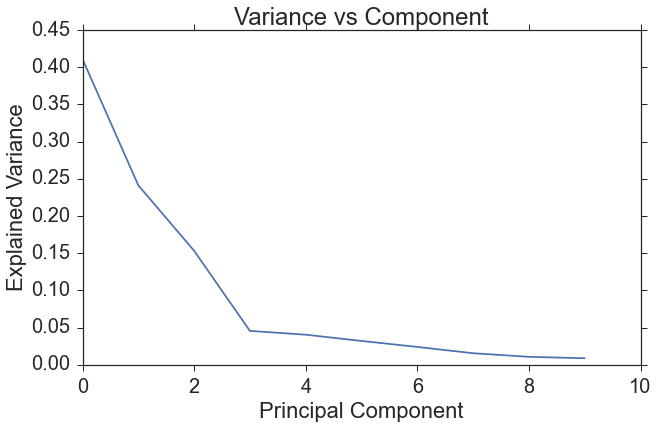

In [10]:
ax = plot_scaled_variance(pca)

Great, so now we’re in business. There are various rules of thumb for selecting the number of principal components to retain in an analysis of this type. Let's pick the number of components which explain 85% or greater of the variation.

So, we will keep the first 4 principal components (remember that we are counting from zero, so we are keeping 0th, 1st, 2nd, and 3rd components&mdash;four components). Let's apply the dimensional reduction on the scaled data.

- Function `reduce()` takes a PCA model (that is already trained on array) and a Numpy array, and applies dimensional reduction on the array. 

In [11]:
reduced = reduce(pca, scaled)

## Clustering.

Let's apply some $k$-means clustering algorithm on Delta Air Lines' aircrafts.

### k-means

- Function `cluster()` fits a k-means clustering algorithm, and returns a tuple `(sklearn.cluster.k_means_.KMeans, np.array)`.
- The second element of the tuple is a 1-d array that contains the predictions of k-means clustering, i.e. which cluster each data point belongs to.
- We will call this function below, when creating a pairgrid.

### The elbow method

Now, we would like to apply the k-means clustering technique, but how do we determine k, the number of clusters?

The simplest method is [the elbow method](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method). According to [scikit-learn documentation](http://scikit-learn.org/stable/modules/clustering.html#k-means),

```
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance,
minimizing a criterion known as the inertia or within-cluster sum-of-squares.
```

The scikit-learn documentation on [sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn-cluster-kmeans) says that `sklearn.cluster.KMeans` has the inertia value in the `inertia_` attribute. So we can vary the number of clusters in `KMeans`, plot `KMeans.inertia_` as a function of the number of clusters, and pick the "elbow" in the plot.

- Function `plot_inertia()` will give us a plot to determine the elbow

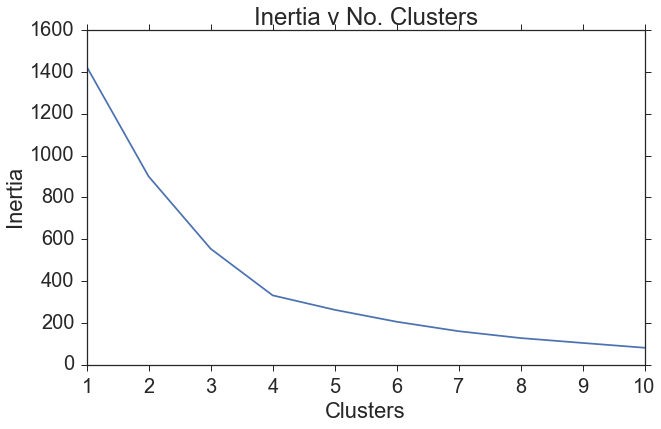

In [12]:
inertia = plot_inertia(reduced)

### Pair Grid

- Function `plot_pair()` uses [seaborn.PairGrid](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.PairGrid.html#) to visualize the clusters in terms of first four principal components.
- The plots on the diagonal will be histograms of corresponding attributes, and the off-diagonals are scatter plots.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


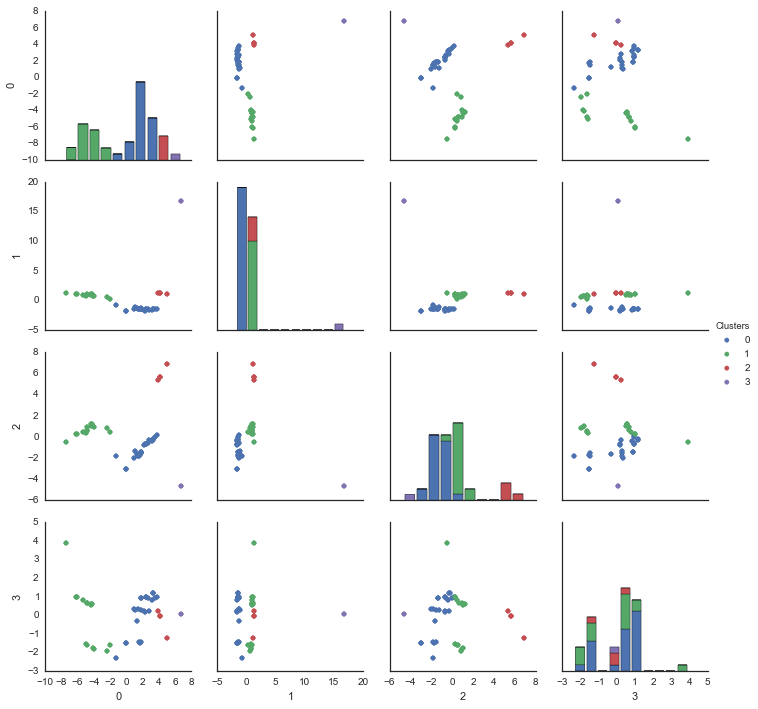

In [13]:
k_means, clusters = cluster(reduced, random_state=check_random_state(0), n_clusters=4)
pg = plot_pair(reduced, clusters)

We can see that the one outlier is in its own cluster, there’s 3 or 4 in the other and the remainder are split into two clusters of greater size.

### Discussion
Let's take a closer look at each cluster.

In [14]:
df['Clusters'] = clusters
df['Aircraft'] = df.index
df_grouped = df.groupby('Clusters').mean()
print(df_grouped.Accommodation)

Clusters
0    153.625000
1    244.733333
2     44.500000
3     54.000000
Name: Accommodation, dtype: float64


In [15]:
print(df_grouped['Length (ft)'])

Clusters
0    137.048083
1    190.538400
2     84.810750
3    111.000000
Name: Length (ft), dtype: float64


Cluster 3 has only one aircraft:

In [16]:
clust3 = df[df.Clusters == 3]
print(clust3.Aircraft)

Aircraft
Airbus A319 VIP    Airbus A319 VIP
Name: Aircraft, dtype: object


Airbus A319 VIP is not one of Delta Airline's regular fleet and is one of Airbus corporate jets.

Cluster 2 has four aircrafts.

In [17]:
clust2 = df[df.Clusters == 2]
print(clust2.Aircraft)

Aircraft
CRJ 100/200 Pinnacle/SkyWest    CRJ 100/200 Pinnacle/SkyWest
CRJ 100/200 ExpressJet                CRJ 100/200 ExpressJet
E120                                                    E120
ERJ-145                                              ERJ-145
Name: Aircraft, dtype: object


These are small aircrafts and only have economy seats.

In [18]:
cols_seat = ['First Class', 'Business', 'Eco Comfort', 'Economy']
print(df.loc[clust2.index, cols_seat])

                              First Class  Business  Eco Comfort  Economy
Aircraft                                                                 
CRJ 100/200 Pinnacle/SkyWest            0         0            0        1
CRJ 100/200 ExpressJet                  0         0            0        1
E120                                    0         0            0        1
ERJ-145                                 0         0            0        1


Next, we look at Cluster 1.

In [19]:
clust1 = df[df.Clusters == 1]
print(clust1.Aircraft)

Aircraft
Airbus A330-200                      Airbus A330-200
Airbus A330-200 (3L2)          Airbus A330-200 (3L2)
Airbus A330-200 (3L3)          Airbus A330-200 (3L3)
Airbus A330-300                      Airbus A330-300
Boeing 747-400 (74S)            Boeing 747-400 (74S)
Boeing 757-200 (75E)            Boeing 757-200 (75E)
Boeing 757-200 (75X)            Boeing 757-200 (75X)
Boeing 767-300 (76G)            Boeing 767-300 (76G)
Boeing 767-300 (76L)            Boeing 767-300 (76L)
Boeing 767-300 (76T)            Boeing 767-300 (76T)
Boeing 767-300 (76Z V.1)    Boeing 767-300 (76Z V.1)
Boeing 767-300 (76Z V.2)    Boeing 767-300 (76Z V.2)
Boeing 767-400 (76D)            Boeing 767-400 (76D)
Boeing 777-200ER                    Boeing 777-200ER
Boeing 777-200LR                    Boeing 777-200LR
Name: Aircraft, dtype: object


These aircrafts do not have first class seating.

In [20]:
print(df.loc[clust1.index, cols_seat])

                          First Class  Business  Eco Comfort  Economy
Aircraft                                                             
Airbus A330-200                     0         1            1        1
Airbus A330-200 (3L2)               0         1            1        1
Airbus A330-200 (3L3)               0         1            1        1
Airbus A330-300                     0         1            1        1
Boeing 747-400 (74S)                0         1            1        1
Boeing 757-200 (75E)                0         1            1        1
Boeing 757-200 (75X)                0         1            1        1
Boeing 767-300 (76G)                0         1            1        1
Boeing 767-300 (76L)                0         1            1        1
Boeing 767-300 (76T)                0         1            1        1
Boeing 767-300 (76Z V.1)            0         1            1        1
Boeing 767-300 (76Z V.2)            0         1            1        1
Boeing 767-400 (76D)

Finally, cluster 0 has the following aircrafts:

In [21]:
clust0 = df[df.Clusters == 0]
print(clust0.Aircraft)

Aircraft
Airbus A319                          Airbus A319
Airbus A320                          Airbus A320
Airbus A320 32-R                Airbus A320 32-R
Boeing 717                            Boeing 717
Boeing 737-700 (73W)        Boeing 737-700 (73W)
Boeing 737-800 (738)        Boeing 737-800 (738)
Boeing 737-800 (73H)        Boeing 737-800 (73H)
Boeing 737-900ER (739)    Boeing 737-900ER (739)
Boeing 757-200 (75A)        Boeing 757-200 (75A)
Boeing 757-200 (75M)        Boeing 757-200 (75M)
Boeing 757-200 (75N)        Boeing 757-200 (75N)
Boeing 757-200 (757)        Boeing 757-200 (757)
Boeing 757-200 (75V)        Boeing 757-200 (75V)
Boeing 757-300                    Boeing 757-300
Boeing 767-300 (76P)        Boeing 767-300 (76P)
Boeing 767-300 (76Q)        Boeing 767-300 (76Q)
Boeing 767-300 (76U)        Boeing 767-300 (76U)
CRJ 700                                  CRJ 700
CRJ 900                                  CRJ 900
E170                                        E170
E175       

The aircrafts in cluster 0 (except for one aircraft) have first class seating but no business class.

In [22]:
print(df.loc[clust0.index, cols_seat])

                        First Class  Business  Eco Comfort  Economy
Aircraft                                                           
Airbus A319                       1         0            1        1
Airbus A320                       1         0            1        1
Airbus A320 32-R                  1         0            1        1
Boeing 717                        1         0            1        1
Boeing 737-700 (73W)              1         0            1        1
Boeing 737-800 (738)              1         0            1        1
Boeing 737-800 (73H)              1         0            1        1
Boeing 737-900ER (739)            1         0            1        1
Boeing 757-200 (75A)              1         0            1        1
Boeing 757-200 (75M)              1         0            1        1
Boeing 757-200 (75N)              1         0            1        1
Boeing 757-200 (757)              1         0            1        1
Boeing 757-200 (75V)              1         0   

## Density Estimation.
The main idea of density estimation is to see if we can create a probability density function on our data, which in many cases will be non-parametric. Using the estimated density function, we could potentially sample new values that vary very similarly to our real data.

We will first plot rug plots and histograms of travel time in the flights data. Then, we can use Seaborn, Scipy, and Scikit-learn to calculate and plot Kernel Density Estimation (KDE).

We use the `AirTime` column at the Willard airport.

In [23]:
df = pd.read_csv(
    '~/2001.csv',
    encoding='latin-1',
    usecols=(13, 16)
    )

In [24]:
local = df[df['Origin'] == 'CMI']
local = local.drop(['Origin'], axis=1) # we don't need the Origin column anymore.
local.dropna(inplace=True)

### Rug plots

- Function `plot_rugplot()` will be able to create rugplots with or without jitter

A rug plot with no jitter.

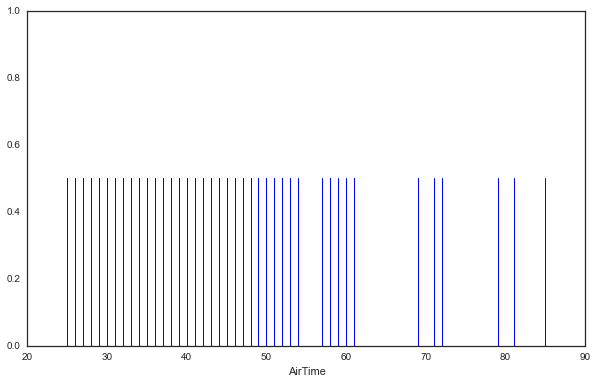

In [25]:
rug_no_jitter = plot_rugplot(df=local, jitter=0, seed=0)

A rug plot with random jitter. Adding jitter improves visualization.

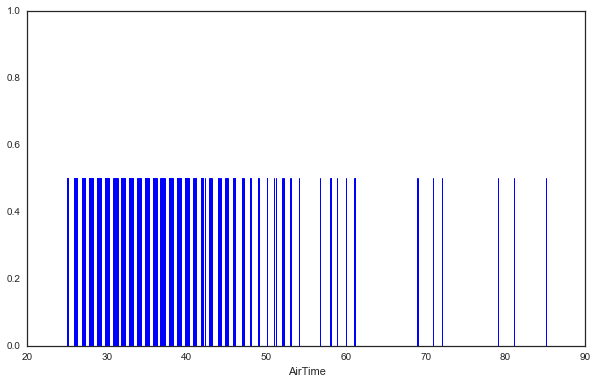

In [26]:
rug_jittered = plot_rugplot(df=local, jitter=0.1, seed=0)

### Histograms

- Now we'll plot histograms using the function `plot_histogram()`
- We can specify the number of bins we want (which will create a more detailed histogram)

A histogram with 10 bins.

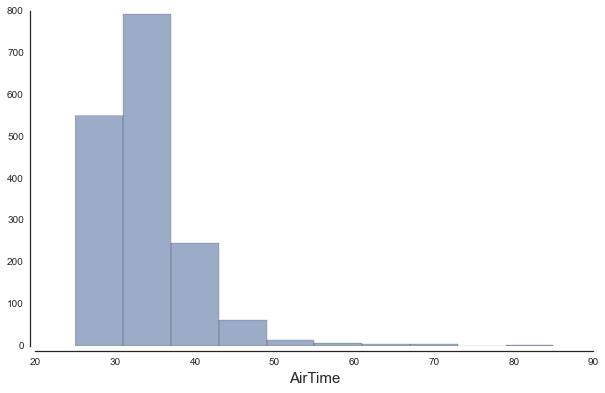

In [27]:
hist_10_bins = plot_histogram(df=local, bins=10)

A histogram with 50 bins. We see that changing the number of bins can have a significant effect on the shape of a histogram. As we will see shortly, KDE is less affected by the choice of bins and thus a better alternative.

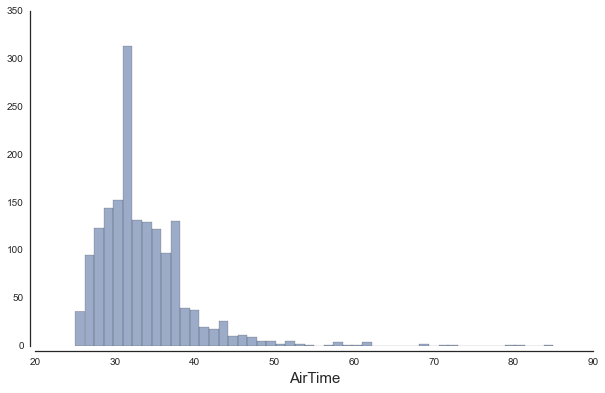

In [28]:
hist_50_bins = plot_histogram(df=local, bins=50)

### distplot

- We can use [seaborn.distplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.distplot.html) to plot a histogram, a KDE, and a rug plot, all in the same figure.
- We accomplish this in the function `plot_distplot()`

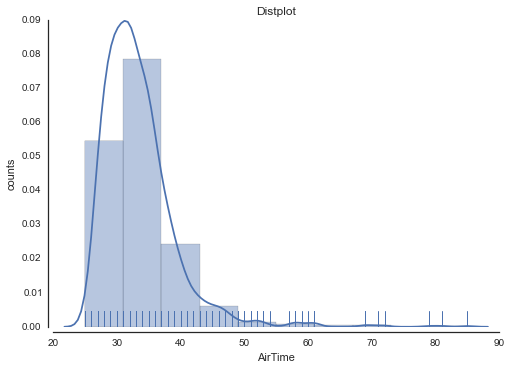

In [29]:
dist_10_bins = plot_distplot(df=local, bins=10)

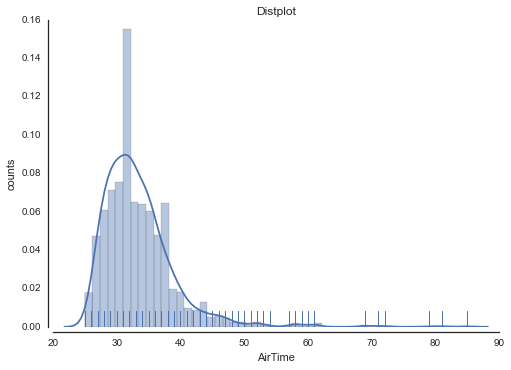

In [30]:
dist_50_bins = plot_distplot(df=local, bins=50)

### Helper functions

#### Silverman's rule of thumb

- Function `get_silverman_bandwidth()` calculates the optimal KDE bandwidth using Silverman's rule of thumb.
- The formula for the optimal choice of bandwidth $h$ is given by

$h = \left( \frac{4{\hat\sigma}^5}{3n} \right)^{\frac{1}{5}} \approx 1.06 \hat\sigma n^{-1/5}$

where $\hat\sigma$ is the standard deviation of the samples. Source: [Wikipedia](https://en.wikipedia.org/wiki/Kernel_density_estimation#Practical_estimation_of_the_bandwidth)

#### Gaussian Kernels

- We can now use `get_silverman_bandwidth()` and [stats.norm().pdf()](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html) to generate Guassian kernels.
- The function is called `get_kernels()`

#### Kernel density estimate

- In order to calculate KDE, we sum up the Gaussian kernels from `get_kernels()` and normalize by the total area.

### Plot KDE (scipy version)

- Now we can use `get_kernels()` and `normalize_kernels()` to plot a KDE and a histogram in the same figure.

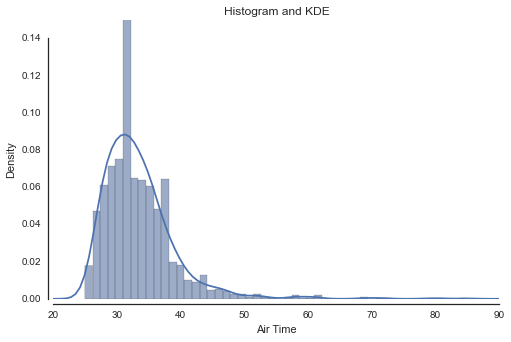

In [31]:
support = np.linspace(20, 90, 100)
kde_scipy = plot_scipy_kde(df=local, support=support)

### Plot KDE (sklearn version)

- Alternatively, we can use the bandwidth calculated with Silverman's rule of thumb and [sklearn.neighbors.KernelDensity](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) to plot our KDE.


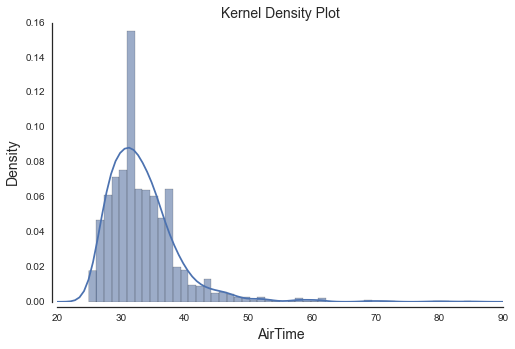

In [32]:
kde_sklearn = plot_sklearn_kde(df=local, support=support)

# Discussion
We first used dimensional reduction and principal component analysis to see if we could classify Delta Air Lines planes by physical characteristics. We used $k$-means clustering based upon the number of principal components we discovered to try and classify the planes.

We were largely successful, as each of our clusters contained similar planes, and between each cluster there were noticable differences.

Finally, we modeled some density estimates on `AirTime`. We can potentially use these estimates to sample new values for `AirTime` that will vary in accordance to our real data.
